In [13]:
import pandas as pd
import folium
import h3

In [2]:
gps_df = pd.read_csv("ch3_gps_sample_v2.csv")
gps_df

,id,lng,lat,is_fraud
0,1010149,126.981566,35.058931,True
1,1010149,126.979396,35.056668,True
2,1010149,126.979395,35.056666,True
3,1010149,126.979395,35.056666,True
4,1010149,126.979397,35.056664,True
...,...,...,...,...
2996,1038215,127.334879,37.351526,False
2997,1038215,127.329981,37.340787,False
2998,1038215,127.326308,37.339377,False
2999,1038215,127.325225,37.338941,False


In [3]:
# 사기건과 비사기건의 id 는 다음과 같습니다.
fraud_list = [1033662, 1023332, 1018336, 1010149]
normal_list = [1037358, 1039563, 1038666, 1038215]

In [4]:
# 시각화하기 위한 함수를 작성합니다.
def visualize(df, id):
    print(id)
    df = df[df['id'] == id]
    coord_list = list(zip(df.lat, df.lng))

    folium_map = folium.Map(location=coord_list[0], zoom_start=11)

    for coord in coord_list:
        folium.CircleMarker(location=[coord[0], coord[1]], fill_color='#43d9de', radius=7).add_to(folium_map)

    return folium_map

### 일반 사고 건 시각화

In [5]:
visualize(gps_df, normal_list[0])

1037358


In [6]:
visualize(gps_df, normal_list[1])

1039563


In [7]:
visualize(gps_df, normal_list[2])

1038666


In [8]:
visualize(gps_df, normal_list[3])

1038215


### 보험사기건 시각화


In [9]:
visualize(gps_df, fraud_list[0])

1033662


In [10]:
visualize(gps_df, fraud_list[1])

1023332


In [11]:
visualize(gps_df, fraud_list[2])

1018336


In [12]:
visualize(gps_df, fraud_list[3])

1010149


### 피쳐 엔지니어링

In [14]:
gps_df

,id,lng,lat,is_fraud
0,1010149,126.981566,35.058931,True
1,1010149,126.979396,35.056668,True
2,1010149,126.979395,35.056666,True
3,1010149,126.979395,35.056666,True
4,1010149,126.979397,35.056664,True
...,...,...,...,...
2996,1038215,127.334879,37.351526,False
2997,1038215,127.329981,37.340787,False
2998,1038215,127.326308,37.339377,False
2999,1038215,127.325225,37.338941,False


In [15]:
# 각 좌표의 h3 를 추출합니다.

for index, row in gps_df.iterrows():
    gps_df.loc[index, 'h3'] = h3.geo_to_h3(lat=row['lat'], lng=row['lng'], resolution=7)

In [16]:
# 아래와 같이 h3 칼럼이 생성되었습니다.
gps_df

,id,lng,lat,is_fraud,h3
0,1010149,126.981566,35.058931,True,8730c6228ffffff
1,1010149,126.979396,35.056668,True,8730c6228ffffff
2,1010149,126.979395,35.056666,True,8730c6228ffffff
3,1010149,126.979395,35.056666,True,8730c6228ffffff
4,1010149,126.979397,35.056664,True,8730c6228ffffff
...,...,...,...,...,...
2996,1038215,127.334879,37.351526,False,8730e1428ffffff
2997,1038215,127.329981,37.340787,False,8730e1428ffffff
2998,1038215,127.326308,37.339377,False,8730e1428ffffff
2999,1038215,127.325225,37.338941,False,8730e1428ffffff


In [17]:
# 각 사고에서 특정 h3 의 횟수를 구하기 위한 집계를 수행해보겠습니다

gps_df_prep = gps_df.groupby(['is_fraud', 'id', 'h3'], as_index=False).count()[['is_fraud', 'id', 'h3', 'lat']]
gps_df_prep = gps_df_prep.rename(columns={'lat': 'gps_count'})
gps_df_prep

,is_fraud,id,h3,gps_count
0,False,1037358,8730e142dffffff,2
1,False,1037358,8730e144dffffff,1
2,False,1037358,8730e1463ffffff,2
3,False,1037358,8730e1466ffffff,1
4,False,1037358,8730e146affffff,1
...,...,...,...,...
323,True,1033662,8730c1925ffffff,2
324,True,1033662,8730c1926ffffff,3
325,True,1033662,8730c1931ffffff,14
326,True,1033662,8730c1935ffffff,1


In [18]:
# gpss count 가 해당 사고 주행에서 차지하는 비중을 찾아보겠습니다.

gps_df_prep['total_gps_count_by_id'] = gps_df_prep.groupby(by=['id'])['gps_count'].transform(sum)
gps_df_prep['h3_share'] = gps_df_prep['gps_count'] / gps_df_prep['total_gps_count_by_id']

gps_df_prep

,is_fraud,id,h3,gps_count,total_gps_count_by_id,h3_share
0,False,1037358,8730e142dffffff,2,810,0.002469
1,False,1037358,8730e144dffffff,1,810,0.001235
2,False,1037358,8730e1463ffffff,2,810,0.002469
3,False,1037358,8730e1466ffffff,1,810,0.001235
4,False,1037358,8730e146affffff,1,810,0.001235
...,...,...,...,...,...,...
323,True,1033662,8730c1925ffffff,2,265,0.007547
324,True,1033662,8730c1926ffffff,3,265,0.011321
325,True,1033662,8730c1931ffffff,14,265,0.052830
326,True,1033662,8730c1935ffffff,1,265,0.003774


In [19]:
# 각 사고 id 에서 차지하는 비중이 높은 h3 에 순서를 매깁니다.
gps_df_prep['h3_rank'] = gps_df_prep.groupby('id')['h3_share'].rank(method='first', ascending=False)
gps_df_prep = gps_df_prep.sort_values(by=['id', 'h3_rank'])
gps_df_prep

,is_fraud,id,h3,gps_count,total_gps_count_by_id,h3_share,h3_rank
263,True,1010149,8730c6adeffffff,300,713,0.420757,1.0
257,True,1010149,8730c6ad2ffffff,71,713,0.099579,2.0
245,True,1010149,8730c632cffffff,66,713,0.092567,3.0
233,True,1010149,8730c622cffffff,33,713,0.046283,4.0
232,True,1010149,8730c6228ffffff,32,713,0.044881,5.0
...,...,...,...,...,...,...,...
216,False,1039563,8730e0b81ffffff,1,159,0.006289,32.0
219,False,1039563,8730e0b8dffffff,1,159,0.006289,33.0
225,False,1039563,8730e0bb3ffffff,1,159,0.006289,34.0
226,False,1039563,8730e1d94ffffff,1,159,0.006289,35.0


In [20]:
gps_df_prep = gps_df_prep[gps_df_prep['h3_rank'] < 80]
gps_df_prep

,is_fraud,id,h3,gps_count,total_gps_count_by_id,h3_share,h3_rank
263,True,1010149,8730c6adeffffff,300,713,0.420757,1.0
257,True,1010149,8730c6ad2ffffff,71,713,0.099579,2.0
245,True,1010149,8730c632cffffff,66,713,0.092567,3.0
233,True,1010149,8730c622cffffff,33,713,0.046283,4.0
232,True,1010149,8730c6228ffffff,32,713,0.044881,5.0
...,...,...,...,...,...,...,...
216,False,1039563,8730e0b81ffffff,1,159,0.006289,32.0
219,False,1039563,8730e0b8dffffff,1,159,0.006289,33.0
225,False,1039563,8730e0bb3ffffff,1,159,0.006289,34.0
226,False,1039563,8730e1d94ffffff,1,159,0.006289,35.0


C:\Users\김영준\PycharmProjects\aiffel_study\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


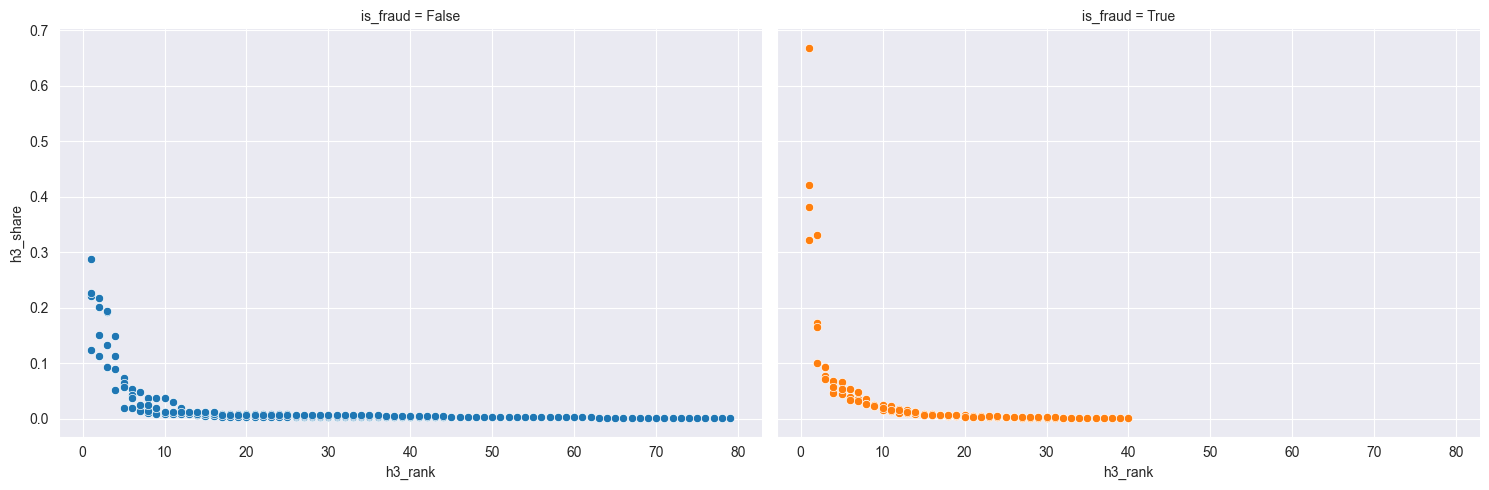

In [21]:
import seaborn as sns
g = sns.FacetGrid(gps_df_prep, col="is_fraud", hue="is_fraud",  height=5, aspect=1.5)
g.map(sns.scatterplot, "h3_rank", "h3_share")

위 시각화 결과에서 왼쪽 그래프는 일반 사고건을 그래프 한 것이고, 오른쪽 그래프는 보험 사기건 시각화한 것입니다.

x축은 h3이고, y축은 해당 h3이 전체 주행에서 차지하는 비율을 나타냅니다.

일반(정상) 사고건은 여러 H3 에 걸쳐 운행합니다. 그리고 상위 H3의 주행 비율이 0.1 ~ 0.3 사이에 분포하는 것을 알 수 있습니다.

반면 보험사기 주행건은 일반 건 대비 적은 수의 H3 을 운행하며, 상위 H3 주행 비율이 0.3 ~ 0.7 에 달합니다.

이 수치의 의미는 보험사기일 경우 특정 지역에서 반복적으로 주행한 비율이 높다는 뜻입니다. 이를 통해 보험 사기 건 주행의 특성을 시각화하고 수치적으로 확인해보았습니다. 이는 보험사기를 예측하는 주요한 피쳐로 사용됩니다.